In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

# 自定义的函数模块
from functions.data import prepare_dataset
from functions.model import UNet

In [2]:
train_data, test_data = prepare_dataset("Lucchi++") # Lucchi++ /  Kasthuri++ / VNC
# # Path to the chest-ct-segmentation dataset folder
# data_dir = "dataset\Lucchi++" 
# train_images_dir = os.path.join(data_dir, "Train_In")
# train_masks_dir = os.path.join(data_dir, "Train_Out")
# test_images_dir = os.path.join(data_dir, "Test_In")
# test_masks_dir = os.path.join(data_dir, "Test_Out")


# i = 0
# # Prepare the training data, Append image and corresponding mask paths
# train_data = []
# for image_file in os.listdir(train_images_dir):
#     image_path = os.path.join(train_images_dir, image_file)
#     mask_path = os.path.join(train_masks_dir, f"{i}.png")
#     i += 1
#     train_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })

# i = 0
# # Prepare the test data, Append image and corresponding mask paths
# test_data = []
# for image_file in os.listdir(test_images_dir):
#     image_path = os.path.join(test_images_dir, image_file)
#     mask_path = os.path.join(test_masks_dir, f"{i}.png")
#     i += 1
#     test_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })
# print(train_data)



Train Data (Lucchi++): [{'image': 'dataset\\Lucchi++\\Train_In\\mask0000.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\0.png', 'index': 0}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0001.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\1.png', 'index': 1}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0002.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\2.png', 'index': 2}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0003.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\3.png', 'index': 3}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0004.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\4.png', 'index': 4}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0005.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\5.png', 'index': 5}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0006.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\6.png', 'index': 6}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0007.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\7.png', 'index': 7}, {'image'

In [3]:
from functions.data import SegmentationDataset

# 创建数据集
train_dataset = SegmentationDataset(
    data_list=train_data,          # 必需：数据列表
    patch_size=128,                # 可选：patch大小，默认128
    stride=128,                     # 可选：滑动步长，默认64
    transform=None,
    # preProcessing= None# 可选：数据增强转换，默认None
)

开始数据集预处理...


处理图像: 100%|██████████| 165/165 [00:12<00:00, 12.76it/s]

数据集预处理完成，共生成 8004 个patch


In [4]:
# 打印数据集基本信息
train_dataset.print_dataset_info()

# 随机查看几张图片的patches
# train_dataset.visualize_random_images(num_images=0, patches_per_image=6)



数据集信息:
总样本数: 8004
图像块大小: 128x128
滑动步长: 128
是否使用数据增强: 否

数据形状:
图像块形状: torch.Size([3, 128, 128])
掩码块形状: torch.Size([1, 128, 128])


In [5]:
# Add reconstruction function
from functions.model import reconstruct_from_patches

# Training function
from functions.model import train_model

# Inference function
from functions.model import predict


# 開始預測流程

In [6]:
# Load the selected image and mask
# 获取预测的mask
from functions.model import segmentation_pipeline
model_path = "models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth"  # 模型路径

# image_path = "dataset/Lucchi++/Test_In/mask0055.png"  # 测试图片路径
# mask_path = "dataset/Lucchi++/Test_Out/55.png"  # 真实掩码路径（如果有）

image_path = "dataset/Lucchi++/Test_In/mask0130.png"  
mask_path = "dataset/Lucchi++/Test_Out/130.png"  


# image_path = "dataset/VNC/Test_In/16.tif"  
# mask_path = "dataset/VNC/Test_Out/16.png"  

save_dir = "test/predictData"  # 结果保存目录
patch_size = 256  # patch大小
stride = 128  # 步长
predicted_mask, metrics = segmentation_pipeline(model_path, image_path, mask_path)

from functions.samPrediction import read_image

image, org_mask = read_image(image_path=image_path, mask_path=mask_path) 

处理图像: mask0130
使用设备: cuda
模型路径: models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth
模型已从 models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth 加载
原始图像尺寸: 768x1024
预处理后图像尺寸: 768x1024
填充信息: 上=0, 下=0, 左=0, 右=0
评估指标: IoU=0.8431, Dice=0.9149
原始预测指标: IoU=0.8431, Dice=0.9149
后处理后指标: IoU=0.8428, Dice=0.9147
指标改善: IoU: -0.04%, Dice: -0.02%


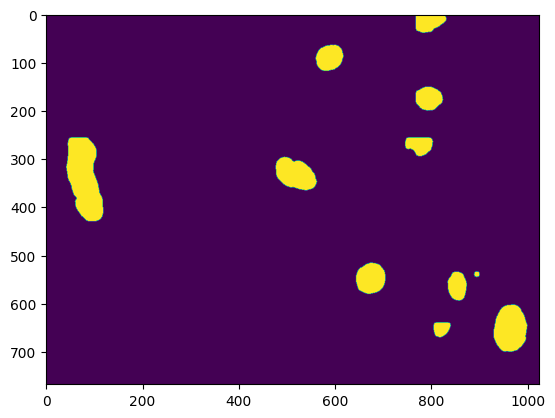

In [7]:
from functions.imagePreprocessing import ImagePreprocessor

from matplotlib import pyplot as plt

plt.imshow(predicted_mask)

# predicted_mask = ImagePreprocessor.advanced_denoise(
#     input_image=predicted_mask
# )

# plt.imshow(predicted_mask)

Creating SAM2 segmentation Model...
SAM2 segmentation Model Created!
Original Prediction IoU: 0.8428
Generating random points for the input......


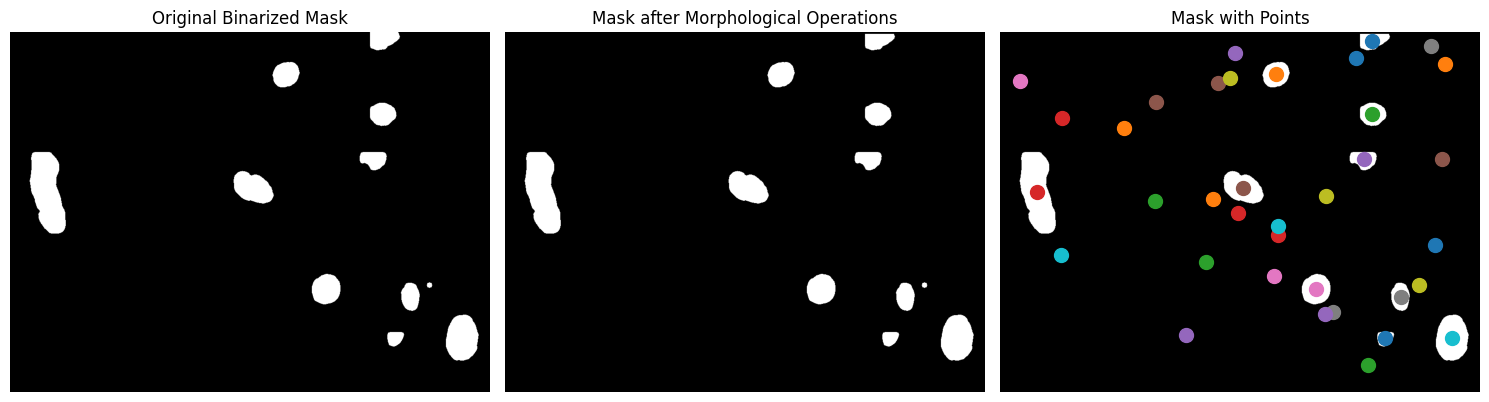

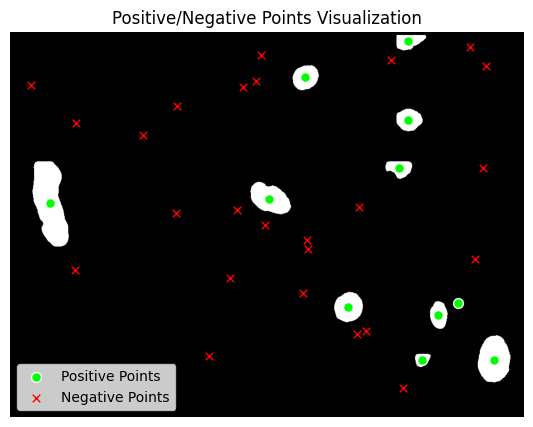

Generated 36 points for the input
输入点坐标维度: (36, 1, 2)
输入标签维度: (36, 1)
输入标签维度: (36, 1)
Sam Model predicting......
input_labels: [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
input_points: [[[794  18]]

 [[588  90]]

 [[794 175]]

 [[ 79 340]]

 [[775 271]]

 [[517 332]]

 [[674 548]]

 [[854 564]]

 [[894 540]]

 [[964 653]]

 [[821 653]]

 [[453 355]]

 [[784 710]]

 [[593 432]]

 [[500  45]]

 [[465 109]]

 [[584 520]]

 [[918  29]]

 [[695 349]]

 [[129 475]]

 [[759  56]]

 [[949  68]]

 [[330 361]]

 [[132 182]]

 [[396 645]]

 [[943 270]]

 [[ 42 105]]

 [[710 596]]

 [[491  98]]

 [[592 414]]

 [[927 453]]

 [[264 204]]

 [[439 491]]

 [[508 385]]

 [[692 601]]

 [[332 148]]]


f:\github\segment-anything-2\sam2\modeling\backbones\hieradet.py:70: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)

Sam Model predict done!
[9.3274516e-01 7.9372925e-01 9.4099772e-01 9.7334301e-01 9.3641013e-01
 9.5611936e-01 9.7489822e-01 9.5020056e-01 9.3951929e-01 9.7420007e-01
 9.3005097e-01 6.4538874e-02 5.6225884e-01 2.3909966e-02 3.0110148e-01
 6.0689884e-01 4.6484613e-01 3.5032935e-03 6.8366737e-03 5.7380546e-02
 1.8568577e-01 2.2134056e-02 9.4759470e-04 2.3258679e-02 1.4288259e-01
 8.6529516e-03 7.6270305e-02 1.2207781e-01 2.0901883e-01 1.8175544e-02
 8.5093267e-03 1.0047825e-03 1.3746318e-01 8.2215166e-01 3.4159642e-01
 1.5014048e-01]

Performance Metrics:
Original IoU: 0.8428
Enhanced IoU: 0.7904
IoU Improvement: -6.22%
Processing Time: 2.36 seconds


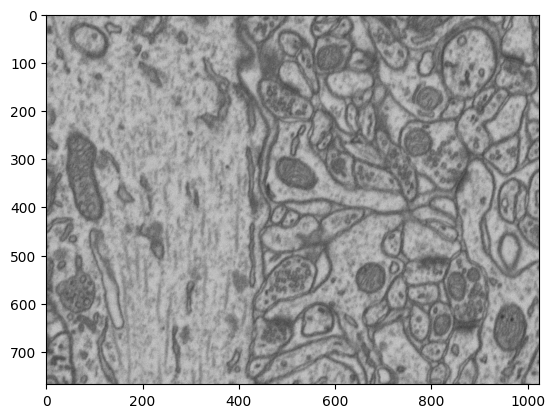

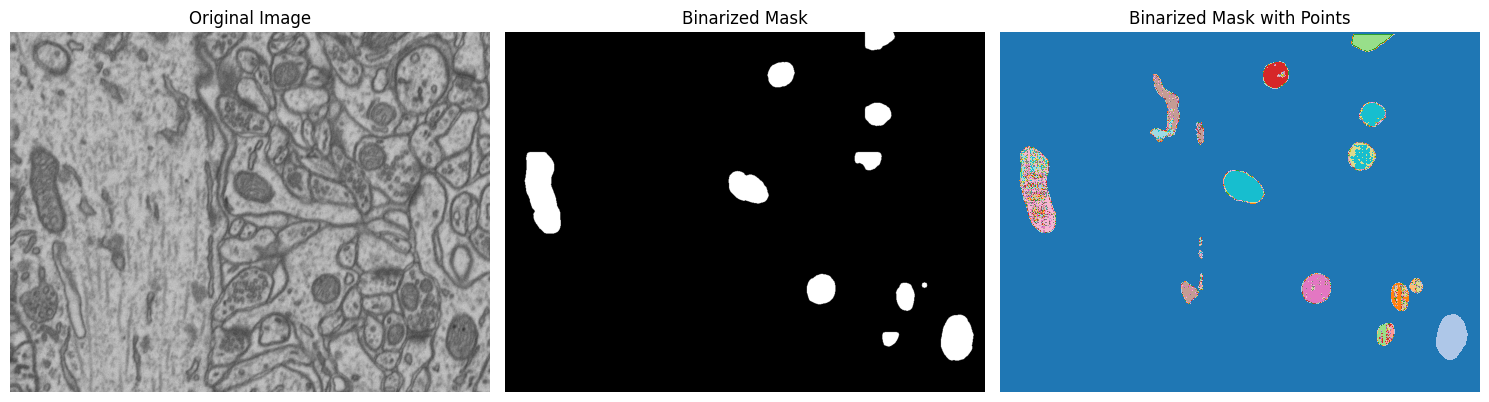

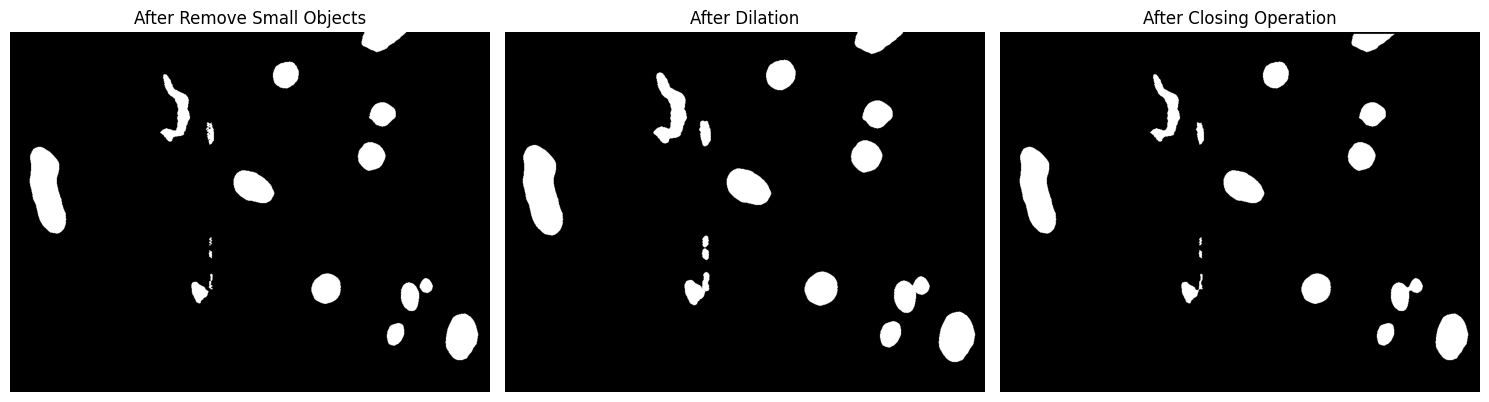

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 0.8427957828973057,
 0.790395582511089,
 2.364532947540283)

In [8]:
from functions.samPrediction import main_prediction_process
from functions.samPrediction import build_sam2_model

sam2_model = build_sam2_model(
        sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt", 
        model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml",
)

main_prediction_process(
    sam2_model=sam2_model,
    image=image,
    predicted_mask=predicted_mask,
    ground_truth_mask=org_mask
)